# Solow-Swan model with human capital

**Table of contents**<a id='toc0_'></a>   
- 1. [The Solow model with human capital](#toc1_)    
- 2. [Analytical solution](#toc2_)
  - 2.1. [Nullclines](#toc2_1_)  
  - 2.2. [Steady state human and physical capital](#toc2_2_)  
- 3. [Numerical solution](#toc3_)    
  - 3.1. [Phase-diagrams](#toc3_1_)
- 4. [Extension to the Solow model with human capital](#toc4_)
  - 4.1. [Simulation of the Solow model with human capital and tax](#toc4_1_)
- 5. [Concluding notes and description of a numerical solution using and algorithm](#toc5_)
	- 5.1 [Algorithm (unassociated)](#toc5_1_)
	- 5.2 [Conclusion](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
sm.init_printing(use_unicode=True) # for pretty printing
import matplotlib.pyplot as plt # par modul
import ipywidgets as widgets
from ipywidgets import interact, fixed
from types import SimpleNamespace

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject



## 1. <a id='toc1_'></a>[The Solow model with human capital](#toc0_)

We will be working with a Solow model with physical and human capital. 
Like physical capital, in the standard Solow model, human capital accumulates. A fixed rate depreciates each period, and a constant fraction $s_H$ of production is saved for further human capital in the next period. Human capital can be thought of as stocks accumulating (without depreciation) such as education, health and IQ.  

The Solow-model with human capital can be found in *Introducing Advanced Macroeconomics* by H.J. Whitta-Jacobsen and P.B. Sørensen.


## Variables 

* $Y_t$ : Production
* $L_t$ : Labor
* $A_t$ : Technology
* $K_t$ : Physical Capital
* $H_t$ : Human Capital

## Parameters

* $s_h$:       Savings/Investments in human capital
* $s_k$:       Savings/Investments in physical capital
* $g$:         Growth rate of technology
* $n$:         Growth rate of the labor force
* $\delta$:    Depreciation rate of physical capital
* $\alpha$:    Return on physical capital
* $\phi$:      Return on human capital
* $h$:         Human capital per effective worker (Stock)

## Equations 

**Production function** 

$ Y_{t}=K_{t}^{\alpha}H_{t}^{\varphi}(A_{t}L_{t})^{1-\alpha-\varphi} $

**Total savings** \
Constant fraction of production in the economy

$ S_t = (s_H+s_K)Y_t,\, s_H+s_K\in(0,1) $

**Capital Accumulation**

$ K_{t+1}=s_{K}Y_t+(1-\delta)K_{t}$

**Human capital accumulation** 

$ H_{t+1} = s_{H}Y_t+(1-\delta)H_t $

**Population and technology growth (TFP)**

$ L_{t+1} = (1+n)L_t $

$ A_{t+1} = (1+g)A_t $

## Tilde equations

In order to analyse the model we calculate the per effective worker values. That is, divide by the population size and technology level. 


**Definitions**

Production, physical capital and human capital divided by popluation and technology to get: \
$   \tilde{y}_{t} = \frac{Y_{t}} {A_tL_t} $\
$   \tilde{k}_{t} = \frac{K_{t}} {A_tL_t} $\
$   \tilde{h}_{t} = \frac{H_{t}} {A_tL_t} $

**Transition Equations** 

The tilde transition equations can be found by inserting the tilde definitions:

$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{k}_{t}] $

$ \tilde{h}_{t+1}= \frac{1}{(1+n)(1+g)}[s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{h}_{t}] $



**OBS: In the following, the tilde values will simply be writen as uncapitalized letters**



## 2. <a id='toc2_'></a>[Analytical solution](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Nullclines](#toc0_)

Calling the function that derives the nullclines and prints latex code from the py-file 

In [10]:
out =  modelproject.analytical()

Nullclines for physical capital: 


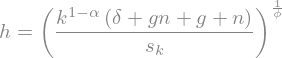

In [11]:
print('Nullclines for physical capital: ')
out['nult_k_eq']

Nullclines for human capital: 


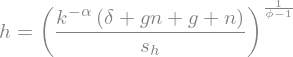

In [12]:
print('Nullclines for human capital: ')
out['nult_h_eq']

### 2.2. <a id='toc2_2_'></a>[Steady state, human and physical capital](#toc0_)


Solving for the steady state yields the following levels of physical and human capital:

Steady state value of physical capital:
$$\tilde{k}^{\ast}=\left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$


Steady state value of human capital:
$$\tilde{h}^{\ast}=\left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$


There are cross-effects, meaning that an increase in the savings rate for physical capital increases both the level of human and physical capital, and vice versa. 

## 3. <a id='toc3_'></a>[Numerical solution](#toc0_)

We now progress to the numerical solution to the Solow-Swan-model with human capital accumulation

After obtaining the analytical solution, we can use numerical methods to verify the results and investigate the dynamics of the model. In this section, we solve the model numerically using the root-finding method in SciPy library. Additionally, we will explore the long-run dynamics of the model and examine the impact of different parameter values on the steady-state levels of capital and labor. The steady state is optained when the level of physical and human capital per effective worker is constant, i.e. a long run solution.

In [5]:
# a. Setting up baseline parameters
par = modelproject.par

# b. Setting up the objective and solving the model
objective = lambda x: [modelproject.f(x[0],x[1],par.s_h,par.s_k,par.g,par.n,par.alpha,par.phi,par.delta)]
solution = optimize.root(objective,[1,1],method = 'broyden1')
num_solution = solution.x

# c. Printing the results
print(f'The level of human and physical capital per effective worker \n in steady state are = {num_solution[0]:.3f} and {num_solution[1]:.3f}, respectively.')


The level of human and physical capital per effective worker 
 in steady state are = 33.350 and 64.134, respectively.


c:\Users\mathi\Desktop\Kandidat i økonomi\1. Semester\Introduction to programming and numerical analysis\Assignments\projects-2023-mathias-emma-S-ren\modelproject\modelproject.py:87: RuntimeWarning: invalid value encountered in double_scalars
  h_function = 1/((1+n)*(1+g))*(s_h*k**(alpha)*h**(phi)+(1-delta)*h)-h
c:\Users\mathi\Desktop\Kandidat i økonomi\1. Semester\Introduction to programming and numerical analysis\Assignments\projects-2023-mathias-emma-S-ren\modelproject\modelproject.py:88: RuntimeWarning: invalid value encountered in double_scalars
  k_function = 1/((1+n)*(1+g))*(s_k*k**(alpha)*h**(phi)+(1-delta)*k)-k
c:\Users\mathi\anaconda3\lib\site-packages\scipy\optimize\_nonlin.py:911: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)


### 3.1. <a id='toc3_1_'></a>[Phase-diagrams](#toc0_)

The phase-diagram can be used to illustrate that there only exist a single point where both human and physical capital per effective worker is constant, which is characterized as our steady state:

$\Delta\tilde{h}^{\ast}=\Delta\tilde{k}^{\ast}=0$ 


The phase-diagram consists of two nullclines where $\Delta\tilde{h}^{\ast}=0$ and $\Delta\tilde{k}^{\ast}=0$, repsectively.


*Unfortunately, the widgets do not work in Git, so the interactive plot here and the one in the last section can only be viewed in VSC.* 

In [6]:
interact(modelproject.solve_ss,  
         s_h=(0, 0.3, 0.01), 
         s_k=(0.2, 0.35, 0.01), 
         g=(0, 0.1, 0.01), 
         n=(0, 0.1, 0.01), 
         alpha=(0.2, 0.5, 0.05), 
         phi=(0.2, 0.5, 0.05), 
         delta=(0.005, 0.05, 0.001))


interactive(children=(FloatSlider(value=0.13, description='s_h', max=0.3, step=0.01), FloatSlider(value=0.25, …

<function modelproject.solve_ss(s_h=0.13, s_k=0.25, g=0.016, n=0.014, alpha=0.3333333333333333, phi=0.3333333333333333, delta=0.02)>

## 4. <a id='toc4_'></a>[Extension to the Solow model with human capital](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Simulation of the Solow Model with Human Capital and tax](#toc0_)

In the following simulation, we consider a simplified version of the Solow model with human capital, where we assume a constant population growth rate $n$, savings rate for physical capital $s_k$, human capital $s_h$, technological growth $g$, depreciation rate $\delta$, capital share $\alpha$, human capital share $\phi$, tax rate on physical capital investment $\tau$, and the effect of human capital on investment $\eta$. The parameter $\eta$ in this model represents the fraction of the tax paid on physical capital to the government, which is subsequently allocated to investment in human capital. This allocation of tax revenue towards human capital investment has the potential to stimulate higher levels of overall investment in the economy.

The simulation starts with initial values for the different variables and iterates over 1000 periods. The graph is interactive, which means we can gain insights into the relationship between investment, capital accumulation, human capital development, and economic growth by changing the parameters.

The Solow model with human capital highlights the importance of both physical and human capital in driving long-term economic growth. It emphasizes that investing in human capital, such as education and skills development, can have significant positive effects on output and productivity. The model also demonstrates how changes in savings rates, population growth, technological progress, and policies such as taxes can impact the accumulation of capital and human capital, ultimately influencing economic growth rates.


In [7]:
interact(modelproject.solow_model, 
         s_h = fixed(par.s_h),
         s_k = fixed(par.s_k), 
         g = fixed(par.g), 
         n = fixed(par.n), 
         alpha = fixed(par.alpha), 
         phi = fixed(par.phi), 
         delta = fixed(par.delta),
         tau=(0, 1, 0.01), 
         eta=(0, 1, 0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), FloatSlider(value=0.05, d…

<function modelproject.solow_model(s_h=0.13, s_k=0.25, g=0.016, n=0.014, alpha=0.3333333333333333, phi=0.3333333333333333, delta=0.02, tau=0.1, eta=0.05)>

## 5. <a id='toc5_'></a>[Concluding notes and description of a numerical solution using and algorithm](#toc0_)

## 5.1. <a id='toc4_1_'></a>[Algorithm (unassociated)](#toc0_)

The algorithm 'find_root()' is a basic implementation of the Newton-Raphson method for solving non-linear equations. 
Below we state a detalied description of the algorithm and the corresponding code, from lecture 3 - Non-linear equations notebook. 

1. Initialization. The algorithm starts by setting up an initital guess $x_0$ for the root of the function $f(x)$, a maximum number og iterations 'max_iter' and a toloerence level $tol$
2. Evaluation of Function and Derivative. In every iteration, it evalutes the function $f(x)$ and its derivative $f'(x)$ at he guess $x_0$. 
3. Convergence Check. It then checks if the aboslutte value of the function at the guess is less than the tolorence level - $|f(x)| < tol$ or if the maximum number of iterations 'max_iter' which have been defined by yourself is reached.
If one of the conditions is satified, it stops the algorithm. 
4. Update Guess: In case the algorithm has not stopped, it creates a new guess $x_k = x -f(x)/ f'(x)$
5. Increment: It then increments the counter $k$ marking the completion of one iteration.
6. Output(return) The last commands says that if fullinfo flag is 'True' the functions returns the values of $x$ tried, the total number of iterations and the corresponding values for $f(x)$ and $f'(x)$. In case fullinfo is not true, it returns the last guess of the root and the number og iterations. 



In [ ]:
def find_root(x0,f,df,max_iter=500,tol=1e-8,full_info=False):
    """ find root
        
    Args:
    
        x0 (float): initial value
        f (callable): function
        df (callable): derivative
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        full_info (bool): controls information returned
        
    Returns:
    
        x (float/ndarray): root (if full_info, all x tried)
        k (int): number of iterations used
        fx (ndarray): function values used (if full_info) 
        fpx (ndarray): derivative values used (if full_info)
        
    """
    
    # initialize
    xs = []
    fxs = []
    dfxs = []
    
    # iterate
    x_k = x0    
    k = 0    
    while True:
        
        x = x_k

        # step 2: evaluate function and derivatives
        fx = f(x)
        dfx = df(x)
        
        # store info
        xs.append(x)
        fxs.append(fx)
        dfxs.append(dfx)

        # step 3: check convergence
        if abs(fx) < tol or k >= max_iter:
            break
            
        # step 4: update x
        x_k = x - fx/dfx
        
        # step 5: increment counter
        k += 1
        
    # return
    if full_info:
        return np.array(xs),k,np.array(fxs),np.array(dfxs)
    else:
        return x,k

## 5.2. <a id='toc5._2_'></a>[Conclusion](#toc0_)


In conclusion, the Solow model with human capital has provided valuable insights into the dynamics of economic growth by incorporating the role of human capital and exploring the impact of various parameters.

Firstly, we identified an analytical solution to the Solow model with human capital, which allowed us to understand the theoretical relationships between savings, production, and the accumulation of physical and human capital. This analytical framework provided a solid foundation for further analysis.

Secondly, we developed a numerical solution to determine the steady-state value of the model. By iteratively calculating the values of capital per effective worker and human capital per effective worker, we were able to identify the long-term equilibrium levels and understand the convergence dynamics of the model. The numerical solution helped us understand how the economy behaves in different situations.

Lastly, we introduced a tax on physical capital and examined the effects of allocating tax revenue to human capital investment. This extension of the model allowed us to analyze the impact of fiscal policies on economic growth and resource allocation. By considering the fraction of tax revenue allocated to human capital investment, we explored the potential to enhance investment levels and promote sustainable development through targeted allocations.
